In [35]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from datetime import datetime, date
from imblearn.under_sampling import *

import codecs
import csv
import urllib.request
import pandas as pd
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import urllib
import json

warnings.filterwarnings(action="ignore")
%matplotlib inline


In [2]:
######## Todo: 검색해서 보기!!#######

In [3]:
origin = pd.read_csv('AFSNT.csv', encoding="cp949")
origin.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR
0,2017,1,1,일,ARP1,ARP3,A,A1901,SEw3Nzc2,D,N,6:10,6:18,N,NaN,N,NaN
1,2017,1,1,일,ARP1,ARP3,A,A1905,SEw4MjM2,D,N,6:15,6:25,N,NaN,N,NaN
2,2017,1,1,일,ARP1,ARP3,L,L1751,SEw4MjM3,D,N,6:20,6:30,N,NaN,N,NaN
3,2017,1,1,일,ARP1,ARP3,F,F1201,SEw4MjA3,D,N,6:25,6:34,N,NaN,N,NaN
4,2017,1,1,일,ARP3,ARP1,A,A1900,SEw3NzAz,D,N,6:30,6:37,N,NaN,N,NaN


In [4]:
origin.rename(columns={'SDT_YY':'Year', 'SDT_MM':'Month', 'SDT_DD':'DAY'}, inplace=True)

#### 'STT'의 시간단위만 추출해 'hour'에 저장
origin['hour']=pd.to_datetime(origin['STT'],format= '%H:%M').dt.hour



####'SDT_DY'를 categorical 데이터로 수정

## Todo: 요일은 계속 원핫???
one_hot_dy = pd.get_dummies(origin['SDT_DY'])
origin = origin.drop(['SDT_DY'],axis = 1)
origin = origin.join(one_hot_dy)
origin.rename(columns={"일":"Sun","월":"Mon","화":"Tue","수":"Wed","목":"Thu","금":"Fri","토":"SAT","일":"Sun"                    
                  }, inplace=True)

In [5]:
#### 한 자리수 데이터를 앞에 '0'을 붙여 두 자리로 변환
def changeDate(data):
    data=str(data)
    if len(data)==1:
        data="0"+data
    return data

In [6]:
####군공항을 제외한 날씨 데이터를 다운받는 함수(공항공사 데이터)

def downloadAirport(yy,mm,area):
    mm=changeDate(mm)
    yy=str(yy)
    url='http://amoapi.kma.go.kr/amoApi/air_stcs?icao='+area+'&yyyymm='+yy+mm
    response = urllib.request.urlopen(url)
    cr = csv.reader(codecs.iterdecode(response, 'utf-8'))
    
    #### url로 읽어와 데이터 프레임에 저장
    temp=[]
    for line in cr:
        temp.append(line)
    
    labels=temp[0]
    weather=pd.DataFrame.from_records(temp[1:],columns=labels)
    
    weather["TM"]=weather["TM"].astype("str")

    weather["Year"]=weather["TM"].str.slice(0,4)
    weather["Month"]=weather["TM"].str.slice(4,6)
    weather["DAY"]=weather["TM"].str.slice(6,8)
    hh=weather["TM"].str.slice(8,10)
    weather['hour']=hh

    weather['hour']= weather['hour'].astype('int')
    weather['hour']=weather['hour'].replace(24,0)
    
    #### 분석에 필요하지 않은 column 삭제
    weather.drop(columns=["TM"], axis=1, inplace=True)
    weather.drop(columns=["PA","WD","WS_GST","RVR1","RVR2","RVR3","RVR4","CLA_1LYR"
               ,"BASE_1LYR","CLF_1LYR","CLA_2LYR","BASE_2LYR","CLF_2LYR",
               "CLA_3LYR","BASE_3LYR","CLF_3LYR","CLA_4LYR","BASE_4LYR","CLF_4LYR","VIS",'CA_TOT'], axis=1, inplace=True)
    
    
    #### 기록이 안 되어 있는 데이터에 '0'을 채워줌
    weather=weather.fillna(0)
    weather["Year"]=weather["Year"].astype("int")
    weather["Month"]=weather["Month"].astype("int")
    weather["DAY"]=weather["DAY"].astype("int")
    
    return weather 

In [7]:
#### 항공데이터에서 제공하지 않는 군공항 데이터를 기상청 날씨데이터를 사용해 다운받는 함수(기상청 csv)
def downloadWeather(year):
    filename="data/"+str(year)+".csv"
    weather=pd.read_csv(filename,encoding="cp949")
    
    #### 일시의 데이트타입과 시간을 따로 저장
    weather["일시"] = weather["일시"].astype('str')
    date=weather["일시"].str.split(expand=True)
    day=date[0].str.split("-",expand=True)
    
    weather["Year"]=day[0]
    weather["Month"]=day[1]
    weather["DAY"]=day[2]
    
    
    weather["hour"]=date[1]
    
    #### 일시 drop(변경 전 데이터)
    weather.drop(columns=['일시'], axis=1, inplace=True)
    #### 분석에 필요하지 않은 column 삭제
    weather = weather.drop(['지면온도(°C)',"지면온도 QC플래그","5cm 지중온도(°C)","10cm 지중온도(°C)","20cm 지중온도(°C)","기온 QC플래그",
                            "강수량 QC플래그","풍속 QC플래그","풍향(16방위)","풍향 QC플래그","습도 QC플래그","현지기압 QC플래그",
                            "해면기압 QC플래그","중하층운량(10분위)","운형(운형약어)","최저운고(100m )","지면상태(지면상태코드)",
                           "적설(cm)","3시간신적설(cm)", "전운량(10분위)","30cm 지중온도(°C)","일조(hr)","일조 QC플래그","일사(MJ/m2)","해면기압(hPa)","시정(10m)"],axis = 1)
    
    #### 한글을 사용함으로써 발생하는 오류를 방지하기 위해 column명들을 영어로 rename
    weather.rename(columns={"지점" : "area", "기온(°C)":"temp" ,"강수량(mm)":"rain", "풍속(m/s)":"windSpeed",
                            "습도(%)":"hum","증기압(hPa)":"Vapor","이슬점온도(°C)":"dew","현지기압(hPa)":"hpa",
                            "현상번호(국내식)":"weatherCode"}, inplace=True)
    
    #### merge시에 타입이 같아야 하므로 데이터타입을 int형으로 변환
    weather["hour"]=weather["hour"].astype("str")
    weather["hour"]=weather["hour"].str.split(":",expand=True)[0]
    weather["hour"]=weather["hour"].astype("int")
    
    weather["Year"]=weather["Year"].astype("int")
    weather["Month"]=weather["Month"].astype("int")
    weather["DAY"]=weather["DAY"].astype("int")
    
    #### 기록이 안 되어 있는 데이터에 '0'을 채워줌    
    weather=weather.fillna(0)
    return weather

In [8]:
#### 군공항을 제외한 항공들의 날씨 데이터와 기상 정보를 merge하는 함수
def mergeAirportData():
    df_all=pd.DataFrame()
    #### 군공항을 제외한 항공들만 저장
    temp=origin[(origin.ARP=="ARP1") | (origin.ARP=="ARP3")| (origin.ARP=="ARP5") | (origin.ARP=="ARP7") 
                | (origin.ARP=="ARP9")| (origin.ARP=="ARP10") ]
    
    elements,count=np.unique(temp["ARP"],return_counts=True)
    
    #### 각각의 공항에 대하여 월별로 데이터를 찾아 merge하고 DataFrame형태로 저장하는 loop문
    for i in range(len(elements)):
        df_areaD=pd.DataFrame()
        arp=elements[i]
        area={"ARP1":"RKSS","ARP3":"RKPC","ARP5":"RKPU",
              "ARP7":"RKJB","ARP9":"RKJY","ARP10":"RKNY"}.get(arp)
        df_areaD=temp[temp["ARP"]==arp]
        
        for j in range(3):
            year=2017+j
            for k in range(12):
                #### 2019년은 데이터가 6월까지만 존재함
                if year==2019:
                    if k>=6:
                        break;
                month=1+k
                df_date=df_areaD[(df_areaD["Year"]==year) & (df_areaD["Month"]==month)]
                weather=downloadAirport(year,month,area)
                df_new=pd.merge(df_areaD,weather,on=["Year","Month","DAY","hour"])
                
                if i==0 and j==0 and k==0:
                    df_all=df_new.copy()
                else:
                    df_all=df_all.append(df_new)
                    
    #### 기상청데이터와 연결 하기 위해 rename                
    df_all.rename(columns={'WSPD':'windSpeed',"TMP":"temp",
                      "TD":"dew",'PS':'hpa','RN':'rain','HM':'hum',
                        'WC':"weatherCode"}, inplace=True)
    
    
    #### 기상청에서 받아온 파일과 함께 저장하기 위해 항공공사의 데이터의 단위를 조정함
    df_all['temp']=df_all['temp'].astype("float")/10
    df_all['hpa']=df_all['hpa'].astype("float")/10
    #df_all['seeHpa']=df_all['seeHpa'].astype("float")/10
    df_all['dew']=df_all['dew'].astype("float")/10
    df_all['windSpeed']=df_all['windSpeed'].astype("float")*1852/3600
    
    return df_all

In [9]:
#### 군공항에 대해 기상청을 통해 불러온 날씨 데이터와 기상 정보를 merge하는 함수
def mergeWeatherData():
    temp=origin[(origin.ARP=="ARP2") | (origin.ARP=="ARP4")| (origin.ARP=="ARP6") | (origin.ARP=="ARP8") | (origin.ARP=="ARP11")
                | (origin.ARP=="ARP12")| (origin.ARP=="ARP13")| (origin.ARP=="ARP14")|(origin.ARP=="ARP15")]
    
    elements,count=np.unique(temp["ARP"],return_counts=True)
    
    #### 각각의 공항에 대하여 연별로 데이터를 찾아 merge하고 저장하는 loop문
    for i in range(3):
        df_areaD=pd.DataFrame()
        year=2017+i
        weather=downloadWeather(year)
        df_yearD=origin[origin["Year"]==year]
        for j in range(len(elements)):
            arp=elements[j]
            area={"ARP2":159,"ARP4":143,"ARP6":131, "ARP8":156,
                  "ARP11":138,"ARP12":192, "ARP13":140,"ARP14":114,"ARP15":112}.get(arp)
            
            df_areaD=df_yearD[df_yearD["ARP"]==arp]
            df_new=pd.DataFrame()
            weatherT=weather[weather["area"]==area]
           
            df_new=pd.merge(df_areaD,weatherT,on=["DAY","hour","Year","Month"])
        
            if i==0 and j==0:
                df_all=df_new.copy()
            else:
                df_all=df_all.append(df_new)
    return df_all

In [11]:
df_airport=mergeAirportData()
df_nonAirport=mergeWeatherData()

df=df_airport.append(df_nonAirport)

In [12]:
df.drop(['area','Vapor', 'hour'], axis = 1, inplace=True)
#### 데이터가 입력되어있지 않은 것들을 '0'으로 대체함
#df_weather['visible']= df_weather['visible'].replace("", 0)
df['hum']= df['hum'].replace("", 0)

In [13]:
############################################################

In [14]:

df.head()

,AOD,ARP,ATT,CNL,CNR,DAY,DLY,DRR,FLO,FLT,...,Tue,Wed,Year,dew,hpa,hum,rain,temp,weatherCode,windSpeed
0,D,ARP1,6:18,N,NaN,1,N,NaN,A,A1901,...,0,0,2017,-5.7,1029.0,80,,-2.5,10,1.543333
1,D,ARP1,6:25,N,NaN,1,N,NaN,A,A1905,...,0,0,2017,-5.7,1029.0,80,,-2.5,10,1.543333
2,D,ARP1,6:30,N,NaN,1,N,NaN,L,L1751,...,0,0,2017,-5.7,1029.0,80,,-2.5,10,1.543333
3,D,ARP1,6:34,N,NaN,1,N,NaN,F,F1201,...,0,0,2017,-5.7,1029.0,80,,-2.5,10,1.543333
4,D,ARP1,6:38,N,NaN,1,N,NaN,H,H1101,...,0,0,2017,-5.7,1029.0,80,,-2.5,10,1.543333


In [15]:
df = df[df.IRR != "Y"] # 부정기 없애기 
df = df[df.CNL != "Y"]

# 비행기 취소와 관련된 Column 삭제
df.drop(columns=['CNL', 'CNR'], axis=1, inplace=True)

# 사용되지 않을 것 같은 데이터 삭제
df.drop(columns=['REG', 'IRR'], axis=1, inplace=True)

############# 날씨 데이터 추가 후 주석 제거할 것.
# 날씨 관련 안쓰는 feature 삭제
df.drop(columns=['rain', 'weatherCode'], axis=1, inplace=True)


In [16]:
# ATT (actual time data)가 널 값인 레코드 삭제
df = df[pd.notnull(df['ATT'])]
df.isnull().sum()

AOD               0
ARP               0
ATT               0
DAY               0
DLY               0
DRR          841598
FLO               0
FLT               0
Fri               0
Mon               0
Month             0
ODP               0
SAT               0
STT               0
Sun               0
Thu               0
Tue               0
Wed               0
Year              0
dew               0
hpa               0
hum               0
temp              0
windSpeed         0
dtype: int64

In [17]:
# ARP와 ODP가 같은 데이터 --> Wrong data => 삭제
df.drop(df[df['ARP'] == df['ODP']].index, inplace=True)


In [18]:
# Wrong Data제거
df['Diff'] = (pd.to_datetime(df['ATT'],format= '%H:%M') - pd.to_datetime(df['STT'],format= '%H:%M')).dt.seconds.astype('int64')

# STT와 ATT 격차 큰 순대로 정렬
# df = df.sort_values(by=['Diff'], ascending=False)

#---------------------------- 출발 비행기 -------------------------------------
# max_delay_hour: 딜레이가 최대 A 시간이라고 가정 -> A시간 이상 지연 Data 삭제 
max_delay_hour = 5
max_delay = max_delay_hour * 3600 # seconds

# 1. 예정시간보다 빨리 출발한 Data삭제 
# 2. max_delay보다 큰 값을 가지는 Data 삭제
df = df[((df['Diff'] <= max_delay) & (df['AOD']=='D')) | (df['AOD']=='A')]


#---------------------------- 도착 비행기 -------------------------------------
# max_delay_hour_arr : 도착 딜레이가 최대 A시간이라고 가정 
max_delay_hour_arr = 5
max_delay_arr = max_delay_hour_arr * 3600 # seconds


# min_delay: 도착 시간이 예정보다 A분 빠를 수 있음. A보다 빨리 도착할 수 없다고 가정
min_delay = 30*60
min_delay = 86400 - min_delay  # 86400(24시간)보다 위인거만 살려놓기

# 1. 예정시간보다 min_dealy보다 더 빨리 도착하는 경우 삭제
# 2. max_delay보다 큰 값을 가지는 Data 삭제
df = df[(df['AOD']=='D') |((df['Diff'] <= max_delay_arr) & (df['AOD']=='A')) | ((df['AOD']=='A')& (df['Diff'] >= min_delay )) ]
df.loc[df['Diff'] >=min_delay, 'Diff'] = df.loc[df['Diff'] >=min_delay, 'Diff']  - 86400


In [19]:
# Z-score을 통한 Outlier 제거 
z = np.abs(stats.zscore(df['hpa']))
threshold = 3
df = df[df["hpa"]>z]
           

In [20]:
#############################################################
# 안개 모델 생성 (fog.py)

In [21]:
# 안개 예측을 위한 row와 column만 저장
df_fog = df[(df['DRR'] =='A01')|(df['DLY']=='N')]
df_fog = df[["temp","hum","dew","windSpeed","DLY"]]

df_fog.head()

,temp,hum,dew,windSpeed,DLY
0,-2.5,80,-5.7,1.543333,N
1,-2.5,80,-5.7,1.543333,N
2,-2.5,80,-5.7,1.543333,N
3,-2.5,80,-5.7,1.543333,N
4,-2.5,80,-5.7,1.543333,N


In [22]:
# Z-score을 통한 Outlier 제거 
z = np.abs(stats.zscore(df_fog._get_numeric_data()))
threshold = 3

df_fog = df_fog[(z < threshold).all(axis=1)]

In [23]:
# Scaling
scaler = MinMaxScaler()
df_fog[['hum', 'dew','temp','windSpeed']] = scaler.fit_transform(df_fog[['hum', 'dew','temp','windSpeed']])

In [24]:
# DLY의 Y, N을 1, 0으로 변경
le = preprocessing.LabelEncoder()
df_fog[['DLY']] = le.fit_transform(df_fog[['DLY']])

In [25]:
def makeTestSet(df):
    X = df.drop(['DLY'], axis = 1)
    y = df['DLY']
        
    X_tr, X_t, y_tr, y_t = train_test_split(X,y, test_size= 0.3, random_state = 42)
    
    print("X_train set--------------------")
    print("Shape:",X_tr.shape)
    print("Target:")
    print(y_tr.value_counts())
    print()
      
    print("X_test set info-----------------")
    print("Shape:",X_t.shape)
    print("Target:")
    print(y_t.value_counts())
    print()

    return [X_tr, X_t, y_tr, y_t]

In [26]:
# Training, Test set 분리
fog_X_train, fog_X_test, fog_y_train, fog_y_test = makeTestSet(df_fog)

X_train set--------------------
Shape: (658037, 4)
Target:
0    580337
1     77700
Name: DLY, dtype: int64

X_test set info-----------------
Shape: (282017, 4)
Target:
0    248552
1     33465
Name: DLY, dtype: int64



In [27]:
# Under sampling
fog_X_samp, fog_y_samp = RandomUnderSampler(random_state=0).fit_sample(fog_X_train, fog_y_train)

In [28]:
# fog 모델 학습

fog_model_RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# 모델 학습하기
fog_model_RF.fit(fog_X_samp, fog_y_samp)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [29]:
######################################################################

In [30]:
#--------------- fog 모델 돌리기 --------------

## INPUT : 'temp', 'hum', 'dew', 'windSpeed' 4가지 Column의 DataFrame
def fogPreProcessing (df):
    # 비어있는 값 0으로 대체
    #print(df.isnull().sum())
    df.fillna(0, inplace = True)
  
    # MinMaxScaling
    scaler = MinMaxScaler()
    df[['hum', 'dew','temp','windSpeed']] = scaler.fit_transform(df[['hum', 'dew','temp','windSpeed']])
  
    return df


In [31]:
# df에서 DRR column 제거
df.drop(columns=['DRR'], axis=1, inplace=True)

fog = df[["temp","hum","dew","windSpeed"]]

fog = fogPreProcessing(fog)

In [37]:

# 예측할 때 확률로가져오기!
result = fog_model_RF.predict_proba(fog)

fog_column = []

# fog_column에 확률값 저장
for i in result:
    fog_column.append(i[1])

In [38]:
df['fog'] = fog_column

df.drop(columns=['hum', 'dew','temp','windSpeed'], axis=1, inplace=True)

df.head()
#------------------------------------------------------------

,AOD,ARP,ATT,DAY,DLY,FLO,FLT,Fri,Mon,Month,...,SAT,STT,Sun,Thu,Tue,Wed,Year,hpa,Diff,fog
0,D,ARP1,6:18,1,N,A,A1901,0,0,1,...,0,6:10,1,0,0,0,2017,1029.0,480,0.419034
1,D,ARP1,6:25,1,N,A,A1905,0,0,1,...,0,6:15,1,0,0,0,2017,1029.0,600,0.419034
2,D,ARP1,6:30,1,N,L,L1751,0,0,1,...,0,6:20,1,0,0,0,2017,1029.0,600,0.419034
3,D,ARP1,6:34,1,N,F,F1201,0,0,1,...,0,6:25,1,0,0,0,2017,1029.0,540,0.419034
4,D,ARP1,6:38,1,N,H,H1101,0,0,1,...,0,6:30,1,0,0,0,2017,1029.0,480,0.419034


In [39]:
# ARP 경로 파생변수 생성
df['ARPODP'] = df['ARP'] + '_' + df['ODP']

In [40]:
# 시간:분 -> 시간+분
df['time']= df['STT'].str.replace(':','')

df.drop(['FLT'], axis=1, inplace = True)

#날짜 년, 일 제거
df.drop(['Year', 'DAY'], axis=1, inplace = True)

df.drop(['ATT','STT','Diff'], axis = 1, inplace=True)


In [41]:
df['time']= df['time'].astype('int')
scaler = MinMaxScaler()
df[['time']] = scaler.fit_transform(df[['time']])


In [42]:
#  카테고리 데이터 Label 인코딩
le = preprocessing.LabelEncoder()
df[['DLY']] = le.fit_transform(df[['DLY']])
df[['ARP']] = le.fit_transform(df[['ARP']])
df[['ODP']] = le.fit_transform(df[['ODP']])
df[['FLO']] = le.fit_transform(df[['FLO']])
df[['ARPODP']] = le.fit_transform(df[['ARPODP']])

In [43]:
# 도착, 출발 데이터 분리
df_A = df[df['AOD']=='A']
df_D = df[df['AOD']=='D']

# AOD column삭제 
df_A = df_A.drop(['AOD'],axis = 1)
df_D = df_D.drop(['AOD'],axis = 1)


In [44]:
X_train_A, X_test_A, y_train_A, y_test_A = makeTestSet(df_A)
X_train_D, X_test_D, y_train_D, y_test_D = makeTestSet(df_D)

X_train set--------------------
Shape: (334948, 15)
Target:
0    312632
1     22316
Name: DLY, dtype: int64

X_test set info-----------------
Shape: (143550, 15)
Target:
0    134062
1      9488
Name: DLY, dtype: int64

X_train set--------------------
Shape: (334477, 15)
Target:
0    275889
1     58588
Name: DLY, dtype: int64

X_test set info-----------------
Shape: (143348, 15)
Target:
0    118199
1     25149
Name: DLY, dtype: int64



In [45]:
# ROC Curve그리기
def plot_roc_curve(fpr, tpr):
       
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [46]:
def confusion_matrix_heatmap(y_true, y_pred):
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [47]:
def runModel (X_train, y_train, X_test, y_test, AOD = True):
    
   
    models = [] 
    
    # Departure Data
    if AOD == True:
        print("Departure Data")
        models.append(('XGB', XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                                            silent=True, nthread=1,subsample=1.0,min_child_weight=5,max_depth=5,gamma=5,colsample_bytree=0.6)))
    # Arrival Data (Todo: Arrival Data에 맞는 파라미터 조정)
    else:
        print("Arrival Data")
        models.append(('XGB', XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                                            silent=True, nthread=1,subsample=1.0,min_child_weight=5,max_depth=5,gamma=5,colsample_bytree=0.6)))
        
        
    # 평가
    results = []
    names = []
    scoring = 'recall'

    seed = 7
    for name, model in models:

        model.fit(X_train, y_train)
        y_predict = pd.Series(model.predict(X_test))

        # Resets index to compare original test data with predicted data
        y_test = y_test.reset_index(drop=True)
        y_predict = y_predict.reset_index(drop=True)


        print(model.score(X_test, y_test))
        print('-' * 50)
        
        #--------ROC Curve-----------------
        probs = model.predict_proba(X_test)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test, probs)
        print('AUC: %.2f' % auc)
        
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        plot_roc_curve(fpr, tpr)
        #-----------------------------------
        
        #-------- Confusion matrix heatmap -----------------
        confusion_matrix_heatmap(y_test, y_predict)
        print(classification_report(y_test, y_predict))
        #---------------------------------------------------
    
        return model
    
    return

Departure Data
0.8274548650835728
--------------------------------------------------
AUC: 0.72


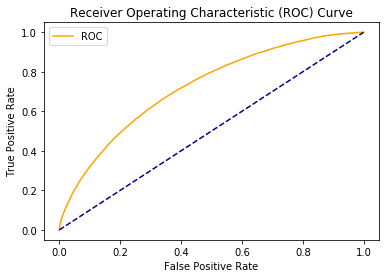

              precision    recall  f1-score   support

           0       0.83      1.00      0.91    118199
           1       0.69      0.03      0.06     25149

    accuracy                           0.83    143348
   macro avg       0.76      0.51      0.48    143348
weighted avg       0.80      0.83      0.76    143348



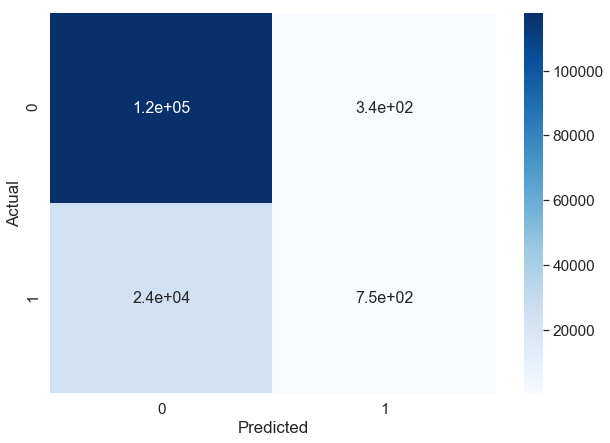

In [48]:
# True: Departure Data
Model_D = runModel (X_train_D,y_train_D, X_test_D, y_test_D, True)

Arrival Data
0.9344270289097876
--------------------------------------------------
AUC: 0.74


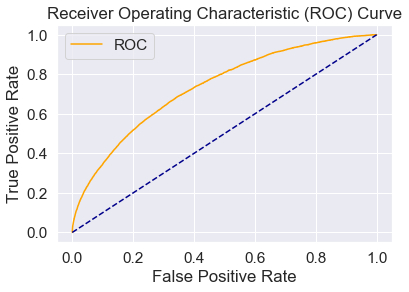

              precision    recall  f1-score   support

           0       0.93      1.00      0.97    134062
           1       0.76      0.01      0.02      9488

    accuracy                           0.93    143550
   macro avg       0.85      0.51      0.49    143550
weighted avg       0.92      0.93      0.90    143550



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=5,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1.0, verbosity=1)

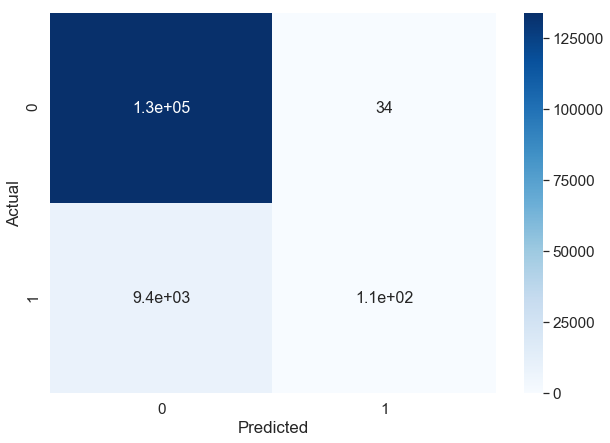

In [49]:
# False: Arrival Data
runModel (X_train_A,y_train_A, X_test_A, y_test_A, False)

In [50]:
# Todo: predict_dly부분 뒤에 추가하기

In [51]:
########################################################################

In [52]:
# read 데이터
dly = pd.read_csv('AFSNT_DLY.CSV', encoding="cp949")
dly.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE
0,2019,9,16,월,ARP1,ARP3,L,L1702,A,9:05,NaN,NaN
1,2019,9,16,월,ARP3,ARP1,L,L1702,D,7:55,NaN,NaN
2,2019,9,16,월,ARP1,ARP3,L,L1720,A,14:40,NaN,NaN
3,2019,9,16,월,ARP3,ARP1,L,L1720,D,13:30,NaN,NaN
4,2019,9,16,월,ARP4,ARP3,L,L1808,A,20:10,NaN,NaN


In [53]:
# hour은 날씨 합칠때 쓰이면 놔두고 안쓰이면 지우기 
dly['hour'] = pd.to_datetime(dly['STT'],format= '%H:%M').dt.hour

In [54]:
# Todo: 여기에 미래날씨 예측 

In [55]:

#날씨데이터 json 읽어오는 함수

#나중에 9월 1일을 9월 16일로 바꾼 후 실행..
#(읽어오는거 확인용으로 9월 1일 부터...)
def readJSON(area):
    
    request = urllib.request.urlopen('https://api.aerisapi.com/forecasts/'+area+',korea?from=09/16/2019&format=json&filter=1hr&limit=999&client_id=gHOhinKWCL1fwDUpI1Ec7&client_secret=TRamBTyXpORXcmDKVqc2S4i4mnCjVxxHMt6cllui')
    response = request.read()
    data= json.loads(response)


    if data['success']:
        return data

    else:
        print("An error occurred: %s" % (data['error']['description']))
        return ""
        request.close()

In [56]:
#날씨 csv 저장
def storeWeather():
    weather=pd.DataFrame(columns=['SDT_YY', 'SDT_MM', 'SDT_DD','hour','ARP','temp', 'hum', 'dew', 'windSpeed','hpa'])

    for i in range(15):
        area=["seoul","busan","jeju","daegu","ulsan","cheongju","muan","gwangju","yeosu"
              ,"yangyang","pohang","sacheon","gunsan","wonju","incheon"]
        d=readJSON(area[i])
        response=d['response'][0]
        data=response['periods']
    
    
        for j in range(len(data)):
            temp=data[j]
            date=dateutil.parser.parse(temp['dateTimeISO'])
            temp2=pd.Series([date.year,date.month,date.day,date.hour,"ARP"+str(i+1),temp['tempC'],
                         temp['humidity'],temp['dewpointC'],temp['windGustKTS'],temp['pressureMB']],
                        index=['SDT_YY', 'SDT_MM', 'SDT_DD','hour','ARP','temp', 'hum', 'dew', 'windSpeed','hpa'])
        
            weather=weather.append(temp2,ignore_index=True)
    
    #fog 모델하고의 단위 맞추는 작업
    weather['windSpeed']=weather['windSpeed'].astype("float")*1852/3600
    
    weather.to_csv("newWeather.csv",index=False)

In [57]:
#미래 날씨 데이터 합치기

from datetime import datetime
now=datetime.now()
if now.day>=16:
    we=pd.read_csv('newWeather.csv', encoding="cp949")
    
else:
    print(now.day)
    storeWeather()
    we=pd.read_csv('newWeather.csv', encoding="cp949")

9


In [58]:
final= pd.merge(we, dly, on=['SDT_YY', 'SDT_MM', 'SDT_DD', 'ARP','hour'])
final

,SDT_YY,SDT_MM,SDT_DD,hour,ARP,temp,hum,dew,windSpeed,hpa,SDT_DY,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE
0,2019,9,16,6,ARP1,21,65,14,2.057778,1015,월,ARP3,L,L1701,D,6:40,NaN,NaN
1,2019,9,16,6,ARP1,21,65,14,2.057778,1015,월,ARP12,J,J1634,D,6:50,NaN,NaN
2,2019,9,16,6,ARP1,21,65,14,2.057778,1015,월,ARP3,F,F1201,D,6:10,NaN,NaN
3,2019,9,16,6,ARP1,21,65,14,2.057778,1015,월,ARP3,F,F1203,D,6:15,NaN,NaN
4,2019,9,16,6,ARP1,21,65,14,2.057778,1015,월,ARP3,J,J1204,D,6:20,NaN,NaN
5,2019,9,16,6,ARP1,21,65,14,2.057778,1015,월,ARP3,A,A1901,D,6:05,NaN,NaN
6,2019,9,16,6,ARP1,21,65,14,2.057778,1015,월,ARP3,H,H1151,D,6:15,NaN,NaN
7,2019,9,16,6,ARP1,21,65,14,2.057778,1015,월,ARP3,F,F1205,D,6:50,NaN,NaN
8,2019,9,16,6,ARP1,21,65,14,2.057778,1015,월,ARP3,A,A1903,D,6:25,NaN,NaN
9,2019,9,16,6,ARP1,21,65,14,2.057778,1015,월,ARP3,H,H1101,D,6:25,NaN,NaN


In [59]:
import warnings
warnings.filterwarnings(action="ignore")

for i in range(5):
    day= dly[dly['SDT_DD']==26+i]
    print(len(day))
    temps=[]
    hums=[]
    dews=[]
    winds=[]

    for j in range(len(day)):
        prev_5= we[ (we['ARP']==day.iloc[j]['ARP']) & (we['hour']==day.iloc[j]['hour']) & 
                      (we['SDT_DD'] >= 26+i-5) & (we['SDT_DD'] < 26+i) ]        
        print('prevs', prev_5)
#        print(len(prev_5))
        temp=0.0
        hum=0.0
        dew=0.0
        windSpeed=0.0

        for k in range(len(prev_5)):
            temp += prev_5.iloc[k]['temp']
            hum += prev_5.iloc[k]['hum']
            dew += prev_5.iloc[k]['dew']
            windSpeed += prev_5.iloc[k]['windSpeed']
        
        if temp > 0:
            temp= temp / len(prev_5)
        if hum > 0:
            hum= hum / len(prev_5)
        if dew > 0:
            dew= dew / len(prev_5)
        if windSpeed > 0:
            windSpeed= windSpeed / len(prev_5)
        
        temps.append(temp)
        hums.append(hum)
        dews.append(dew)
        winds.append(windSpeed)

    day['temp']= temps
    day['hum']=hums
    day['dew']=dews
    day['windSpeed']=winds

    print(day)

    final= final.append(day)
  

1062
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2630    2019       9      21    14  ARP13    20   60   12   8.231111  1018
2654    2019       9      22    14  ARP13    20   56   11   3.601111  1018
2678    2019       9      23    14  ARP13    22   55   12   3.086667  1018
2702    2019       9      24    14  ARP13    23   62   15   1.543333  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
549    2019       9      21    13  ARP3    22   71   16  12.861111  1014
573    2019       9      22    13  ARP3    22   71   16  10.288889  1016
597    2019       9      23    13  ARP3    22   77   18   7.716667  1016
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
543    2019       9      21     7  ARP3    22   73   17  13.375556  1014
567    2019       9      22     7  ARP3    22   72   16  11.317778  1017
591    2019       

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
555    2019       9      21    19  ARP3    22   70   16  12.861111  1015
579    2019       9      22    19  ARP3    22   71   17   9.260000  1016
603    2019       9      23    19  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
545    2019       9      21     9  ARP3    22   72   16  13.375556  1015
569    2019       9      22     9  ARP3    22   72   16  11.317778  1017
593    2019       9      23     9  ARP3    22   78   18   8.231111  1017
617    2019       9      24     9  ARP3    23   80   19   8.745556  1017
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1168    2019       9      21     8  ARP6    15   74   10   6.173333  1020
1192    2019       9      22     8  ARP6    14   76   10   3.086667  1022
1216    2019       9      23     8  ARP6    16   72   11   2.057778  1020
1240    2019       9      24 

prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1590    2019       9      21    14  ARP8    22   51   11   6.173333  1017
1614    2019       9      22    14  ARP8    21   50   10   3.601111  1018
1638    2019       9      23    14  ARP8    22   53   12   2.572222  1017
1662    2019       9      24    14  ARP8    23   55   14   1.543333  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
555    2019       9      21    19  ARP3    22   70   16  12.861111  1015
579    2019       9      22    19  ARP3    22   71   17   9.260000  1016
603    2019       9      23    19  ARP3    23   78   19   7.202222  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1178    2019       9      21    18  ARP6    16   68   10   5.144444  1020
1202    2019       9      22    18  ARP6    17   65   11   3.086667  1019
1226    2019       9      23    18  ARP6    19   66   12   2.572222  1019
prevs      SDT_YY  SDT_M

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
548    2019       9      21    12  ARP3    22   71   16  12.861111  1014
572    2019       9      22    12  ARP3    22   71   16  10.288889  1016
596    2019       9      23    12  ARP3    22   77   18   7.716667  1016
620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
552    2019       9      21    16  ARP3    22   71   16  12.346667  1014
576    2019       9      22    16  ARP3    22   70   16   9.774444  1016
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
135    2019       9      21    15  ARP1    21   49   10   5.144444  1019
159    2019       9      22    15  ARP1    22   46   10   2.057778  1019
183    2019       9      23    15  ARP1    23   44   10   1.543333  1018
207    2019       9      24    15

1038    2019       9      24    14  ARP5    22   72   16   5.144444  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
133    2019       9      21    13  ARP1    19   56   10   5.144444  1020
157    2019       9      22    13  ARP1    19   54   10   2.572222  1020
181    2019       9      23    13  ARP1    21   52   11   2.057778  1019
205    2019       9      24    13  ARP1    22   57   13   1.543333  1019
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1586    2019       9      21    10  ARP8    19   60   11   5.144444  1018
1610    2019       9      22    10  ARP8    18   64   11   3.601111  1019
1634    2019       9      23    10  ARP8    19   65   12   2.572222  1019
1658    2019       9      24    10  ARP8    20   72   15   2.572222  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
129    2019       9      21     9  ARP1    15   69   10   4.630000  1021
153    2019       9      22

189    2019       9      23    21  ARP1    17   69   11   2.057778  1020
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2428    2019       9      21    20  ARP12    14   74    9   4.115556  1021
2452    2019       9      22    20  ARP12    16   70   10   3.086667  1020
2476    2019       9      23    20  ARP12    17   74   12   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
141    2019       9      21    21  ARP1    14   74    9   3.086667  1022
165    2019       9      22    21  ARP1    16   66   10   2.057778  1020
189    2019       9      23    21  ARP1    17   69   11   2.057778  1020
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
972     2019       9      21    20  ARP5    18   73   13  11.317778  1019
996     2019       9      22    20  ARP5    19   75   14   6.687778  1018
1020    2019       9      23    20  ARP5    20   78   16   6.173333  1019
prevs      SDT_YY  SD

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
341    2019       9      21    13  ARP2    20   70   14  14.404444  1017
365    2019       9      22    13  ARP2    21   69   15  10.288889  1017
389    2019       9      23    13  ARP2    22   73   17   7.202222  1017
413    2019       9      24    13  ARP2    22   74   17   6.173333  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
336    2019       9      21     8  ARP2    19   72   14  13.890000  1017
360    2019       9      22     8  ARP2    20   71   14  11.317778  1019
384    2019       9      23     8  ARP2    20   76   16   7.716667  1018
408    2019       9      24     8  ARP2    21   80   17   7.716667  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
127    2019       9      21     7  ARP1    15   75   10   4.115556  1021
151    2019       9      22     7  ARP1    13   74    9   3.086667  1022
175    2019       9      23     7

3112    2019       9      24     8  ARP15    18   76   13   3.086667  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
138    2019       9      21    18  ARP1    17   61    9   4.115556  1021
162    2019       9      22    18  ARP1    19   56   10   2.057778  1020
186    2019       9      23    18  ARP1    20   57   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
346    2019       9      21    18  ARP2    20   71   14  13.890000  1017
370    2019       9      22    18  ARP2    20   71   15   9.260000  1017
394    2019       9      23    18  ARP2    22   75   17   7.716667  1018
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
3040    2019       9      21     8  ARP15    16   72   10   5.144444  1021
3064    2019       9      22     8  ARP15    15   71   10   3.601111  1022
3088    2019       9      23     8  ARP15    17   66   11   2.572222  1020
3112    2019       9   

201    2019       9      24     9  ARP1    17   75   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
336    2019       9      21     8  ARP2    19   72   14  13.890000  1017
360    2019       9      22     8  ARP2    20   71   14  11.317778  1019
384    2019       9      23     8  ARP2    20   76   16   7.716667  1018
408    2019       9      24     8  ARP2    21   80   17   7.716667  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
132    2019       9      21    12  ARP1    18   59   10   4.630000  1020
156    2019       9      22    12  ARP1    18   58    9   2.572222  1021
180    2019       9      23    12  ARP1    20   55   11   2.057778  1020
204    2019       9      24    12  ARP1    21   62   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
339    2019       9      21    11  ARP2    20   71   14  14.404444  1017
363    2019       9      22    11

415    2019       9      24    15  ARP2    22   71   17   5.658889  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
550    2019       9      21    14  ARP3    22   71   16  12.861111  1014
574    2019       9      22    14  ARP3    22   70   16   9.774444  1016
598    2019       9      23    14  ARP3    22   77   18   7.202222  1016
622    2019       9      24    14  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
759    2019       9      21    15  ARP4    18   64   11   8.231111  1018
783    2019       9      22    15  ARP4    19   63   12   5.144444  1018
807    2019       9      23    15  ARP4    21   65   14   3.601111  1018
831    2019       9      24    15  ARP4    22   66   15   3.086667  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
550    2019       9      21    14  ARP3    22   71   16  12.861111  1014
574    2019       9      22    14

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
140    2019       9      21    20  ARP1    15   70    9   3.601111  1021
164    2019       9      22    20  ARP1    17   63   10   2.057778  1020
188    2019       9      23    20  ARP1    18   65   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
549    2019       9      21    13  ARP3    22   71   16  12.861111  1014
573    2019       9      22    13  ARP3    22   71   16  10.288889  1016
597    2019       9      23    13  ARP3    22   77   18   7.716667  1016
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
340    2019       9      21    12  ARP2    20   71   14  14.404444  1017
364    2019       9      22    12  ARP2    20   70   15  10.288889  1018
388    2019       9      23    12  ARP2    21   74   17   7.716667  1018
412    2019       9      24    12

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
133    2019       9      21    13  ARP1    19   56   10   5.144444  1020
157    2019       9      22    13  ARP1    19   54   10   2.572222  1020
181    2019       9      23    13  ARP1    21   52   11   2.057778  1019
205    2019       9      24    13  ARP1    22   57   13   1.543333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
342    2019       9      21    14  ARP2    20   70   14  14.404444  1016
366    2019       9      22    14  ARP2    21   69   15   9.774444  1017
390    2019       9      23    14  ARP2    22   73   17   7.202222  1017
414    2019       9      24    14  ARP2    22   72   17   6.173333  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
548    2019       9      21    12  ARP3    22   71   16  12.861111  1014
572    2019       9      22    12  ARP3    22   71   16  10.288889  1016
596    2019       9      23    12

623    2019       9      24    15  ARP3    23   79   19   7.716667  1015
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
342    2019       9      21    14  ARP2    20   70   14  14.404444  1016
366    2019       9      22    14  ARP2    21   69   15   9.774444  1017
390    2019       9      23    14  ARP2    22   73   17   7.202222  1017
414    2019       9      24    14  ARP2    22   72   17   6.173333  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
548    2019       9      21    12  ARP3    22   71   16  12.861111  1014
572    2019       9      22    12  ARP3    22   71   16  10.288889  1016
596    2019       9      23    12  ARP3    22   77   18   7.716667  1016
620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1171    2019       9      21    11  ARP6    17   67   11   6.687778  1020
1195    2019       9      22   

620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
131    2019       9      21    11  ARP1    17   63   10   4.630000  1021
155    2019       9      22    11  ARP1    17   62    9   2.572222  1021
179    2019       9      23    11  ARP1    19   59   11   2.057778  1020
203    2019       9      24    11  ARP1    20   66   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
552    2019       9      21    16  ARP3    22   71   16  12.346667  1014
576    2019       9      22    16  ARP3    22   70   16   9.774444  1016
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
343    2019       9      21    15  ARP2    20   69   14  14.404444  1016
367    2019       9      22    15  ARP2    21   68   15   9.774444  1017
391    2019       9      23    15

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
132    2019       9      21    12  ARP1    18   59   10   4.630000  1020
156    2019       9      22    12  ARP1    18   58    9   2.572222  1021
180    2019       9      23    12  ARP1    20   55   11   2.057778  1020
204    2019       9      24    12  ARP1    21   62   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
547    2019       9      21    11  ARP3    22   71   16  13.375556  1014
571    2019       9      22    11  ARP3    22   71   16  10.803333  1017
595    2019       9      23    11  ARP3    22   77   18   7.716667  1017
619    2019       9      24    11  ARP3    23   80   19   8.745556  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
136    2019       9      21    16  ARP1    20   53   10   4.630000  1020
160    2019       9      22    16  ARP1    21   49   10   2.057778  1019
184    2019       9      23    16

409    2019       9      24     9  ARP2    21   80   17   7.716667  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
544    2019       9      21     8  ARP3    22   72   17  13.375556  1014
568    2019       9      22     8  ARP3    22   72   16  11.317778  1017
592    2019       9      23     8  ARP3    22   77   18   8.231111  1017
616    2019       9      24     8  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
554    2019       9      21    18  ARP3    22   71   16  12.861111  1015
578    2019       9      22    18  ARP3    22   70   17   9.260000  1016
602    2019       9      23    18  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
345    2019       9      21    17  ARP2    20   70   14  13.890000  1017
369    2019       9      22    17  ARP2    21   70   15   9.260000  1017
393    2019       9      23    17

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
556    2019       9      21    20  ARP3    22   70   16  12.861111  1016
580    2019       9      22    20  ARP3    22   71   17   9.260000  1016
604    2019       9      23    20  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
138    2019       9      21    18  ARP1    17   61    9   4.115556  1021
162    2019       9      22    18  ARP1    19   56   10   2.057778  1020
186    2019       9      23    18  ARP1    20   57   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
127    2019       9      21     7  ARP1    15   75   10   4.115556  1021
151    2019       9      22     7  ARP1    13   74    9   3.086667  1022
175    2019       9      23     7  ARP1    16   69   11   2.057778  1020
199    2019       9      24     7  ARP1    16   78   13   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
127    2019       9      21     7  ARP1    15   75   10   4.115556  1021
151    2019       9      22     7  ARP1    13   74    9   3.086667  1022
175    2019       9      23     7  ARP1    16   69   11   2.057778  1020
199    2019       9      24     7  ARP1    16   78   13   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
132    2019       9      21    12  ARP1    18   59   10   4.630000  1020
156    2019       9      22    12  ARP1    18   58    9   2.572222  1021
180    2019       9      23    12  ARP1    20   55   11   2.057778  1020
204    2019       9      24    12  ARP1    21   62   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
547    2019       9      21    11  ARP3    22   71   16  13.375556  1014
571    2019       9      22    11  ARP3    22   71   16  10.803333  1017
595    2019       9      23    11

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
139    2019       9      21    19  ARP1    16   65    9   4.115556  1021
163    2019       9      22    19  ARP1    18   60   10   2.057778  1020
187    2019       9      23    19  ARP1    19   61   11   2.057778  1020
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1178    2019       9      21    18  ARP6    16   68   10   5.144444  1020
1202    2019       9      22    18  ARP6    17   65   11   3.086667  1019
1226    2019       9      23    18  ARP6    19   66   12   2.572222  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
553    2019       9      21    17  ARP3    22   71   16  12.861111  1015
577    2019       9      22    17  ARP3    22   70   16   9.260000  1016
601    2019       9      23    17  ARP3    23   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
138    2019       9    

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
137    2019       9      21    17  ARP1    19   57   10   4.630000  1020
161    2019       9      22    17  ARP1    20   53   10   2.057778  1019
185    2019       9      23    17  ARP1    21   52   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
552    2019       9      21    16  ARP3    22   71   16  12.346667  1014
576    2019       9      22    16  ARP3    22   70   16   9.774444  1016
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
556    2019       9      21    20  ARP3    22   70   16  12.861111  1016
580    2019       9      22    20  ARP3    22   71   17   9.260000  1016
604    2019       9      23    20  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
139    2019       9      21

201    2019       9      24     9  ARP1    17   75   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
544    2019       9      21     8  ARP3    22   72   17  13.375556  1014
568    2019       9      22     8  ARP3    22   72   16  11.317778  1017
592    2019       9      23     8  ARP3    22   77   18   8.231111  1017
616    2019       9      24     8  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
547    2019       9      21    11  ARP3    22   71   16  13.375556  1014
571    2019       9      22    11  ARP3    22   71   16  10.803333  1017
595    2019       9      23    11  ARP3    22   77   18   7.716667  1017
619    2019       9      24    11  ARP3    23   80   19   8.745556  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
130    2019       9      21    10  ARP1    16   66   10   4.630000  1021
154    2019       9      22    10

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
543    2019       9      21     7  ARP3    22   73   17  13.375556  1014
567    2019       9      22     7  ARP3    22   72   16  11.317778  1017
591    2019       9      23     7  ARP3    22   77   18   8.231111  1016
615    2019       9      24     7  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
126    2019       9      21     6  ARP1    14   78   10   4.115556  1021
150    2019       9      22     6  ARP1    13   76    9   3.086667  1022
174    2019       9      23     6  ARP1    16   69   10   2.057778  1020
198    2019       9      24     6  ARP1    16   80   12   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
134    2019       9      21    14  ARP1    20   52   10   5.144444  1020
158    2019       9      22    14  ARP1    21   50   10   2.057778  1020
182    2019       9      23    14

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
557    2019       9      21    21  ARP3    22   70   16  12.861111  1016
581    2019       9      22    21  ARP3    22   71   17   8.745556  1017
605    2019       9      23    21  ARP3    23   79   19   7.202222  1017
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1176    2019       9      21    16  ARP6    18   61   11   6.173333  1019
1200    2019       9      22    16  ARP6    19   58   11   3.601111  1019
1224    2019       9      23    16  ARP6    21   57   12   2.572222  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
551    2019       9      21    15  ARP3    22   71   16  12.346667  1014
575    2019       9      22    15  ARP3    22   70   16   9.774444  1015
599    2019       9      23    15  ARP3    22   77   18   7.202222  1016
623    2019       9      24    15  ARP3    23   79   19   7.716667  1015
prevs      SDT_YY  SDT_MM  SD

186    2019       9      23    18  ARP1    20   57   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
554    2019       9      21    18  ARP3    22   71   16  12.861111  1015
578    2019       9      22    18  ARP3    22   70   17   9.260000  1016
602    2019       9      23    18  ARP3    23   78   19   7.202222  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1177    2019       9      21    17  ARP6    17   65   10   5.658889  1019
1201    2019       9      22    17  ARP6    18   62   11   3.601111  1019
1225    2019       9      23    17  ARP6    20   61   12   2.572222  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
552    2019       9      21    16  ARP3    22   71   16  12.346667  1014
576    2019       9      22    16  ARP3    22   70   16   9.774444  1016
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SD

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
552    2019       9      21    16  ARP3    22   71   16  12.346667  1014
576    2019       9      22    16  ARP3    22   70   16   9.774444  1016
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
135    2019       9      21    15  ARP1    21   49   10   5.144444  1019
159    2019       9      22    15  ARP1    22   46   10   2.057778  1019
183    2019       9      23    15  ARP1    23   44   10   1.543333  1018
207    2019       9      24    15  ARP1    24   48   12   1.028889  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
556    2019       9      21    20  ARP3    22   70   16  12.861111  1016
580    2019       9      22    20  ARP3    22   71   17   9.260000  1016
604    2019       9      23    20  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
553    2019       9      21    17  ARP3    22   71   16  12.861111  1015
577    2019       9      22    17  ARP3    22   70   16   9.260000  1016
601    2019       9      23    17  ARP3    23   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
554    2019       9      21    18  ARP3    22   71   16  12.861111  1015
578    2019       9      22    18  ARP3    22   70   17   9.260000  1016
602    2019       9      23    18  ARP3    23   78   19   7.202222  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1594    2019       9      21    18  ARP8    20   58   11   5.658889  1018
1618    2019       9      22    18  ARP8    20   57   11   3.086667  1018
1642    2019       9      23    18  ARP8    21   60   13   2.057778  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
551    2019       9    

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
544    2019       9      21     8  ARP3    22   72   17  13.375556  1014
568    2019       9      22     8  ARP3    22   72   16  11.317778  1017
592    2019       9      23     8  ARP3    22   77   18   8.231111  1017
616    2019       9      24     8  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
129    2019       9      21     9  ARP1    15   69   10   4.630000  1021
153    2019       9      22     9  ARP1    15   70    9   3.086667  1022
177    2019       9      23     9  ARP1    17   67   11   2.057778  1021
201    2019       9      24     9  ARP1    17   75   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
547    2019       9      21    11  ARP3    22   71   16  13.375556  1014
571    2019       9      22    11  ARP3    22   71   16  10.803333  1017
595    2019       9      23    11

       SDT_YY  SDT_MM  SDT_DD SDT_DY    ARP    ODP FLO    FLT AOD    STT  DLY  \
10698    2019       9      26      목  ARP13   ARP3   J  J1921   A  14:45  NaN   
10699    2019       9      26      목   ARP3  ARP13   J  J1921   D  13:40  NaN   
10700    2019       9      26      목   ARP3   ARP1   L  L1701   A   7:50  NaN   
10701    2019       9      26      목   ARP1   ARP3   L  L1701   D   6:40  NaN   
10702    2019       9      26      목   ARP1   ARP3   L  L1728   A  18:15  NaN   
10703    2019       9      26      목   ARP3   ARP1   L  L1728   D  17:05  NaN   
10704    2019       9      26      목   ARP3   ARP4   L  L1807   A  17:30  NaN   
10705    2019       9      26      목   ARP4   ARP3   L  L1807   D  16:25  NaN   
10706    2019       9      26      목   ARP1   ARP3   L  L1702   A   9:05  NaN   
10707    2019       9      26      목   ARP3   ARP1   L  L1702   D   7:55  NaN   
10708    2019       9      26      목   ARP1   ARP3   L  L1720   A  14:40  NaN   
10709    2019       9      2

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
578    2019       9      22    18  ARP3    22   70   17   9.260000  1016
602    2019       9      23    18  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
569    2019       9      22     9  ARP3    22   72   16  11.317778  1017
593    2019       9      23     9  ARP3    22   78   18   8.231111  1017
617    2019       9      24     9  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
152    2019       9      22     8  ARP1    14   72    9   3.086667  1022
176    2019       9      23     8  ARP1    17   68   11   2.057778  1020
200    2019       9      24     8  ARP1    17   77   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
579    2019       9      22    19  ARP3    22   71   17   9.260000  1016
603    2019       9      23

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
156    2019       9      22    12  ARP1    18   58    9   2.572222  1021
180    2019       9      23    12  ARP1    20   55   11   2.057778  1020
204    2019       9      24    12  ARP1    21   62   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
571    2019       9      22    11  ARP3    22   71   16  10.803333  1017
595    2019       9      23    11  ARP3    22   77   18   7.716667  1017
619    2019       9      24    11  ARP3    23   80   19   8.745556  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
567    2019       9      22     7  ARP3    22   72   16  11.317778  1017
591    2019       9      23     7  ARP3    22   77   18   8.231111  1016
615    2019       9      24     7  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
774    2019       9      22

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
787    2019       9      22    19  ARP4    15   77   11   3.601111  1019
811    2019       9      23    19  ARP4    18   80   14   3.086667  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
578    2019       9      22    18  ARP3    22   70   17   9.260000  1016
602    2019       9      23    18  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
165    2019       9      22    21  ARP1    16   66   10   2.057778  1020
189    2019       9      23    21  ARP1    17   69   11   2.057778  1020
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
987     2019       9      22    11  ARP5    19   68   13   8.745556  1019
1011    2019       9      23    11  ARP5    21   74   16   6.173333  1018
1035    2019       9      24    11  ARP5    21   77   17   5.658889  1019
prevs      SDT_YY  SDT_

prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2242    2019       9      22    18  ARP11    18   71   12   5.658889  1019
2266    2019       9      23    18  ARP11    19   77   15   4.630000  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
161    2019       9      22    17  ARP1    20   53   10   2.057778  1019
185    2019       9      23    17  ARP1    21   52   11   2.057778  1019
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2451    2019       9      22    19  ARP12    17   66   10   3.086667  1020
2475    2019       9      23    19  ARP12    18   69   12   2.572222  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
162    2019       9      22    18  ARP1    19   56   10   2.057778  1020
186    2019       9      23    18  ARP1    20   57   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
164    20

413    2019       9      24    13  ARP2    22   74   17   6.173333  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
156    2019       9      22    12  ARP1    18   58    9   2.572222  1021
180    2019       9      23    12  ARP1    20   55   11   2.057778  1020
204    2019       9      24    12  ARP1    21   62   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
164    2019       9      22    20  ARP1    17   63   10   2.057778  1020
188    2019       9      23    20  ARP1    18   65   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
371    2019       9      22    19  ARP2    20   72   15   8.745556  1018
395    2019       9      23    19  ARP2    22   75   17   7.716667  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
368    2019       9      22    16  ARP2    21   69   15   9.260000  1017
392    2019       9      23

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
154    2019       9      22    10  ARP1    16   66    9   2.572222  1022
178    2019       9      23    10  ARP1    18   63   11   2.057778  1020
202    2019       9      24    10  ARP1    19   71   13   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
362    2019       9      22    10  ARP2    20   70   14  11.317778  1019
386    2019       9      23    10  ARP2    21   75   16   7.716667  1018
410    2019       9      24    10  ARP2    21   78   17   7.202222  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
369    2019       9      22    17  ARP2    21   70   15   9.260000  1017
393    2019       9      23    17  ARP2    22   74   17   7.202222  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
160    2019       9      22    16  ARP1    21   49   10   2.057778  1019
184    2019       9      23

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
155    2019       9      22    11  ARP1    17   62    9   2.572222  1021
179    2019       9      23    11  ARP1    19   59   11   2.057778  1020
203    2019       9      24    11  ARP1    20   66   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
371    2019       9      22    19  ARP2    20   72   15   8.745556  1018
395    2019       9      23    19  ARP2    22   75   17   7.716667  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
162    2019       9      22    18  ARP1    19   56   10   2.057778  1020
186    2019       9      23    18  ARP1    20   57   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
360    2019       9      22     8  ARP2    20   71   14  11.317778  1019
384    2019       9      23     8  ARP2    20   76   16   7.716667  1018
408    2019       9      24

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
573    2019       9      22    13  ARP3    22   71   16  10.288889  1016
597    2019       9      23    13  ARP3    22   77   18   7.716667  1016
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
161    2019       9      22    17  ARP1    20   53   10   2.057778  1019
185    2019       9      23    17  ARP1    21   52   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
576    2019       9      22    16  ARP3    22   70   16   9.774444  1016
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
165    2019       9      22    21  ARP1    16   66   10   2.057778  1020
189    2019       9      23    21  ARP1    17   69   11   2.057778  1020
prevs      SDT_YY  SDT_MM  

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
572    2019       9      22    12  ARP3    22   71   16  10.288889  1016
596    2019       9      23    12  ARP3    22   77   18   7.716667  1016
620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
155    2019       9      22    11  ARP1    17   62    9   2.572222  1021
179    2019       9      23    11  ARP1    19   59   11   2.057778  1020
203    2019       9      24    11  ARP1    20   66   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
576    2019       9      22    16  ARP3    22   70   16   9.774444  1016
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
159    2019       9      22    15  ARP1    22   46   10   2.057778  1019
183    2019       9      23

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
578    2019       9      22    18  ARP3    22   70   17   9.260000  1016
602    2019       9      23    18  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
582    2019       9      22    22  ARP3    22   72   17   8.745556  1016
606    2019       9      23    22  ARP3    23   79   19   7.716667  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
165    2019       9      22    21  ARP1    16   66   10   2.057778  1020
189    2019       9      23    21  ARP1    17   69   11   2.057778  1020
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1205    2019       9      22    21  ARP6    14   75   10   2.572222  1020
1229    2019       9      23    21  ARP6    16   79   12   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
580    2019       

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
155    2019       9      22    11  ARP1    17   62    9   2.572222  1021
179    2019       9      23    11  ARP1    19   59   11   2.057778  1020
203    2019       9      24    11  ARP1    20   66   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
165    2019       9      22    21  ARP1    16   66   10   2.057778  1020
189    2019       9      23    21  ARP1    17   69   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
580    2019       9      22    20  ARP3    22   71   17   9.260000  1016
604    2019       9      23    20  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
154    2019       9      22    10  ARP1    16   66    9   2.572222  1022
178    2019       9      23    10  ARP1    18   63   11   2.057778  1020
202    2019       9      24

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
573    2019       9      22    13  ARP3    22   71   16  10.288889  1016
597    2019       9      23    13  ARP3    22   77   18   7.716667  1016
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
575    2019       9      22    15  ARP3    22   70   16   9.774444  1015
599    2019       9      23    15  ARP3    22   77   18   7.202222  1016
623    2019       9      24    15  ARP3    23   79   19   7.716667  1015
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
367    2019       9      22    15  ARP2    21   68   15   9.774444  1017
391    2019       9      23    15  ARP2    22   72   17   7.202222  1017
415    2019       9      24    15  ARP2    22   71   17   5.658889  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
153    2019       9      22

621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
165    2019       9      22    21  ARP1    16   66   10   2.057778  1020
189    2019       9      23    21  ARP1    17   69   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
580    2019       9      22    20  ARP3    22   71   17   9.260000  1016
604    2019       9      23    20  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
581    2019       9      22    21  ARP3    22   71   17   8.745556  1017
605    2019       9      23    21  ARP3    23   79   19   7.202222  1017
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1204    2019       9      22    20  ARP6    15   72   10   3.086667  1020
1228    2019       9      23    20  ARP6    17   75   12   2.572222  1019
prevs      SDT_YY  SDT_M

617    2019       9      24     9  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
152    2019       9      22     8  ARP1    14   72    9   3.086667  1022
176    2019       9      23     8  ARP1    17   68   11   2.057778  1020
200    2019       9      24     8  ARP1    17   77   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
567    2019       9      22     7  ARP3    22   72   16  11.317778  1017
591    2019       9      23     7  ARP3    22   77   18   8.231111  1016
615    2019       9      24     7  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
572    2019       9      22    12  ARP3    22   71   16  10.288889  1016
596    2019       9      23    12  ARP3    22   77   18   7.716667  1016
620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD

199    2019       9      24     7  ARP1    16   78   13   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
566    2019       9      22     6  ARP3    22   72   16  11.317778  1016
590    2019       9      23     6  ARP3    22   76   18   8.231111  1016
614    2019       9      24     6  ARP3    23   80   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
157    2019       9      22    13  ARP1    19   54   10   2.572222  1020
181    2019       9      23    13  ARP1    21   52   11   2.057778  1019
205    2019       9      24    13  ARP1    22   57   13   1.543333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
572    2019       9      22    12  ARP3    22   71   16  10.288889  1016
596    2019       9      23    12  ARP3    22   77   18   7.716667  1016
620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD

185    2019       9      23    17  ARP1    21   52   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
576    2019       9      22    16  ARP3    22   70   16   9.774444  1016
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
567    2019       9      22     7  ARP3    22   72   16  11.317778  1017
591    2019       9      23     7  ARP3    22   77   18   8.231111  1016
615    2019       9      24     7  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
150    2019       9      22     6  ARP1    13   76    9   3.086667  1022
174    2019       9      23     6  ARP1    16   69   10   2.057778  1020
198    2019       9      24     6  ARP1    16   80   12   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
569    2019       9      22

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
153    2019       9      22     9  ARP1    15   70    9   3.086667  1022
177    2019       9      23     9  ARP1    17   67   11   2.057778  1021
201    2019       9      24     9  ARP1    17   75   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
152    2019       9      22     8  ARP1    14   72    9   3.086667  1022
176    2019       9      23     8  ARP1    17   68   11   2.057778  1020
200    2019       9      24     8  ARP1    17   77   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
164    2019       9      22    20  ARP1    17   63   10   2.057778  1020
188    2019       9      23    20  ARP1    18   65   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
579    2019       9      22    19  ARP3    22   71   17   9.260000  1016
603    2019       9      23

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
163    2019       9      22    19  ARP1    18   60   10   2.057778  1020
187    2019       9      23    19  ARP1    19   61   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
576    2019       9      22    16  ARP3    22   70   16   9.774444  1016
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1824    2019       9      22    16  ARP9    21   63   14   7.202222  1017
1848    2019       9      23    16  ARP9    22   68   16   5.144444  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
567    2019       9      22     7  ARP3    22   72   16  11.317778  1017
591    2019       9      23     7  ARP3    22   77   18   8.231111  1016
615    2019       9      24     7  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_M

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
575    2019       9      22    15  ARP3    22   70   16   9.774444  1015
599    2019       9      23    15  ARP3    22   77   18   7.202222  1016
623    2019       9      24    15  ARP3    23   79   19   7.716667  1015
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
164    2019       9      22    20  ARP1    17   63   10   2.057778  1020
188    2019       9      23    20  ARP1    18   65   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
579    2019       9      22    19  ARP3    22   71   17   9.260000  1016
603    2019       9      23    19  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
568    2019       9      22     8  ARP3    22   72   16  11.317778  1017
592    2019       9      23     8  ARP3    22   77   18   8.231111  1017
616    2019       9      24

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
571    2019       9      22    11  ARP3    22   71   16  10.803333  1017
595    2019       9      23    11  ARP3    22   77   18   7.716667  1017
619    2019       9      24    11  ARP3    23   80   19   8.745556  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
577    2019       9      22    17  ARP3    22   70   16   9.260000  1016
601    2019       9      23    17  ARP3    23   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
159    2019       9      22    15  ARP1    22   46   10   2.057778  1019
183    2019       9      23    15  ARP1    23   44   10   1.543333  1018
207    2019       9      24    15  ARP1    24   48   12   1.028889  1018
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2650    2019       9      22    10  ARP13    17   70   11   4.630000  1020
2674    2019       9   

187    2019       9      23    19  ARP1    19   61   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
578    2019       9      22    18  ARP3    22   70   17   9.260000  1016
602    2019       9      23    18  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
578    2019       9      22    18  ARP3    22   70   17   9.260000  1016
602    2019       9      23    18  ARP3    23   78   19   7.202222  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2657    2019       9      22    17  ARP13    20   58   11   3.086667  1018
2681    2019       9      23    17  ARP13    21   58   13   3.086667  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
568    2019       9      22     8  ARP3    22   72   16  11.317778  1017
592    2019       9      23     8  ARP3    22   77   18   8.231111  1017
616    2019       9  

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
364    2019       9      22    12  ARP2    20   70   15  10.288889  1018
388    2019       9      23    12  ARP2    21   74   17   7.716667  1018
412    2019       9      24    12  ARP2    22   75   17   6.687778  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
572    2019       9      22    12  ARP3    22   71   16  10.288889  1016
596    2019       9      23    12  ARP3    22   77   18   7.716667  1016
620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
154    2019       9      22    10  ARP1    16   66    9   2.572222  1022
178    2019       9      23    10  ARP1    18   63   11   2.057778  1020
202    2019       9      24    10  ARP1    19   71   13   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
577    2019       9      22

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
568    2019       9      22     8  ARP3    22   72   16  11.317778  1017
592    2019       9      23     8  ARP3    22   77   18   8.231111  1017
616    2019       9      24     8  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
570    2019       9      22    10  ARP3    22   71   16  10.803333  1017
594    2019       9      23    10  ARP3    22   77   18   8.231111  1017
618    2019       9      24    10  ARP3    23   80   19   8.745556  1017
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1609    2019       9      22     9  ARP8    17   67   11   3.601111  1020
1633    2019       9      23     9  ARP8    18   68   12   2.572222  1019
1657    2019       9      24     9  ARP8    19   76   15   2.572222  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
788    2019       9    

809    2019       9      23    17  ARP4    20   73   14   3.086667  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
784    2019       9      22    16  ARP4    18   66   12   4.630000  1018
808    2019       9      23    16  ARP4    20   69   14   3.601111  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
575    2019       9      22    15  ARP3    22   70   16   9.774444  1015
599    2019       9      23    15  ARP3    22   77   18   7.202222  1016
623    2019       9      24    15  ARP3    23   79   19   7.716667  1015
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
576    2019       9      22    16  ARP3    22   70   16   9.774444  1016
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
579    2019       9      22    19  ARP3    22   71   17   9.260000  1016
603    2019       9      23

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
575    2019       9      22    15  ARP3    22   70   16   9.774444  1015
599    2019       9      23    15  ARP3    22   77   18   7.202222  1016
623    2019       9      24    15  ARP3    23   79   19   7.716667  1015
       SDT_YY  SDT_MM  SDT_DD SDT_DY    ARP    ODP FLO    FLT AOD    STT  DLY  \
11760    2019       9      27      금  ARP13   ARP3   J  J1921   A  14:45  NaN   
11761    2019       9      27      금   ARP3  ARP13   J  J1921   D  13:40  NaN   
11762    2019       9      27      금   ARP1   ARP3   L  L1728   A  18:15  NaN   
11763    2019       9      27      금   ARP3   ARP1   L  L1728   D  17:05  NaN   
11764    2019       9      27      금   ARP3   ARP4   L  L1807   A  17:30  NaN   
11765    2019       9      27      금   ARP4   ARP3   L  L1807   D  16:25  NaN   
11766    2019       9      27      금   ARP3   ARP9   J  J1934   A  10:19  NaN   
11767    2019       9      27      금   ARP9   ARP3   J

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
808    2019       9      23    16  ARP4    20   69   14   3.601111  1018
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2678    2019       9      23    14  ARP13    22   55   12   3.086667  1018
2702    2019       9      24    14  ARP13    23   62   15   1.543333  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
597    2019       9      23    13  ARP3    22   77   18   7.716667  1016
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
177    2019       9      23     9  ARP1    17   67   11   2.057778  1021
201    2019       9      24     9  ARP1    17   75   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
591    2019       9      23     7  ARP3    22   77   18   8.231111  1016
615    2019    

620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1636    2019       9      23    12  ARP8    20   59   12   2.572222  1018
1660    2019       9      24    12  ARP8    22   64   14   2.057778  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
596    2019       9      23    12  ARP3    22   77   18   7.716667  1016
620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1219    2019       9      23    11  ARP6    18   65   11   2.057778  1020
1243    2019       9      24    11  ARP6    19   72   14   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
595    2019       9      23    11  ARP3    22   77   18   7.716667  1017
619    2019       9      24    11  ARP3    23   80   19   8.745556  1016
prevs      SDT_YY  SD

prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1422    2019       9      23     6  ARP7    19   67   12   2.572222  1018
1446    2019       9      24     6  ARP7    20   73   15   2.572222  1018
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1229    2019       9      23    21  ARP6    16   79   12   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
604    2019       9      23    20  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
598    2019       9      23    14  ARP3    22   77   18   7.202222  1016
622    2019       9      24    14  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
180    2019       9      23    12  ARP1    20   55   11   2.057778  1020
204    2019       9      24    12  ARP1    21   62   13   2.057778  1020
prevs      SDT_Y

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
184    2019       9      23    16  ARP1    22   48   10   1.543333  1019
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1850    2019       9      23    18  ARP9    21   71   16   5.144444  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
185    2019       9      23    17  ARP1    21   52   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
187    2019       9      23    19  ARP1    19   61   11   2.057778  1020
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1018    2019       9      23    18  ARP5    21   75   16   6.173333  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
186    2019       9      23    18  ARP1    20   57   11   2.057778  1019
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1641

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
181    2019       9      23    13  ARP1    21   52   11   2.057778  1019
205    2019       9      24    13  ARP1    22   57   13   1.543333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
388    2019       9      23    12  ARP2    21   74   17   7.716667  1018
412    2019       9      24    12  ARP2    22   75   17   6.687778  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
389    2019       9      23    13  ARP2    22   73   17   7.202222  1017
413    2019       9      24    13  ARP2    22   74   17   6.173333  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
395    2019       9      23    19  ARP2    22   75   17   7.716667  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
186    2019       9      23    18  ARP1    20   57   11   2.057778  1019
prevs      SDT_YY  SD

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
397    2019       9      23    21  ARP2    21   77   17   7.716667  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
188    2019       9      23    20  ARP1    18   65   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
386    2019       9      23    10  ARP2    21   75   16   7.716667  1018
410    2019       9      24    10  ARP2    21   78   17   7.202222  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
177    2019       9      23     9  ARP1    17   67   11   2.057778  1021
201    2019       9      24     9  ARP1    17   75   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
392    2019       9      23    16  ARP2    22   73   17   7.202222  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
183    2019    

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
185    2019       9      23    17  ARP1    21   52   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
394    2019       9      23    18  ARP2    22   75   17   7.716667  1018
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
3097    2019       9      23    17  ARP15    21   53   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
188    2019       9      23    20  ARP1    18   65   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
396    2019       9      23    20  ARP2    21   76   17   7.716667  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
396    2019       9      23    20  ARP2    21   76   17   7.716667  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
187  

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
595    2019       9      23    11  ARP3    22   77   18   7.716667  1017
619    2019       9      24    11  ARP3    23   80   19   8.745556  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
178    2019       9      23    10  ARP1    18   63   11   2.057778  1020
202    2019       9      24    10  ARP1    19   71   13   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
598    2019       9      23    14  ARP3    22   77   18   7.202222  1016
622    2019       9      24    14  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
181    2019       9      23    13  ARP1    21   52   11   2.057778  1019
205    2019       9      24    13  ARP1    22   57   13   1.543333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
190    2019       9  

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
593    2019       9      23     9  ARP3    22   78   18   8.231111  1017
617    2019       9      24     9  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
175    2019       9      23     7  ARP1    16   69   11   2.057778  1020
199    2019       9      24     7  ARP1    16   78   13   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
186    2019       9      23    18  ARP1    20   57   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
393    2019       9      23    17  ARP2    22   74   17   7.202222  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
600    2019    

619    2019       9      24    11  ARP3    23   80   19   8.745556  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
599    2019       9      23    15  ARP3    22   77   18   7.202222  1016
623    2019       9      24    15  ARP3    23   79   19   7.716667  1015
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
390    2019       9      23    14  ARP2    22   73   17   7.202222  1017
414    2019       9      24    14  ARP2    22   72   17   6.173333  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
183    2019       9      23    15  ARP1    23   44   10   1.543333  1018
207    2019       9      24    15  ARP1    24   48   12   1.028889  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
597    2019       9      23    13  ARP3    22   77   18   7.716667  1016
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  

623    2019       9      24    15  ARP3    23   79   19   7.716667  1015
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
390    2019       9      23    14  ARP2    22   73   17   7.202222  1017
414    2019       9      24    14  ARP2    22   72   17   6.173333  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
591    2019       9      23     7  ARP3    22   77   18   8.231111  1016
615    2019       9      24     7  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
174    2019       9      23     6  ARP1    16   69   10   2.057778  1020
198    2019       9      24     6  ARP1    16   80   12   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
182    2019       9      23    14  ARP1    22   48   11   1.543333  1019
206    2019       9      24    14  ARP1    23   53   12   1.543333  1019
prevs      SDT_YY  SDT_MM  

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
592    2019       9      23     8  ARP3    22   77   18   8.231111  1017
616    2019       9      24     8  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
598    2019       9      23    14  ARP3    22   77   18   7.202222  1016
622    2019       9      24    14  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
181    2019       9      23    13  ARP1    21   52   11   2.057778  1019
205    2019       9      24    13  ARP1    22   57   13   1.543333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
189    2019       9      23    21  ARP1    17   69   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
604    2019       9      23    20  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SD

622    2019       9      24    14  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
604    2019       9      23    20  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
187    2019       9      23    19  ARP1    19   61   11   2.057778  1020
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1230    2019       9      23    22  ARP6    16   81   12   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
605    2019       9      23    21  ARP3    23   79   19   7.202222  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
604    2019       9      23    20  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
187    2019       9      23    19  ARP1    19   61   11   2.057778  1020
prevs      SD

605    2019       9      23    21  ARP3    23   79   19   7.202222  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
592    2019       9      23     8  ARP3    22   77   18   8.231111  1017
616    2019       9      24     8  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
383    2019       9      23     7  ARP2    20   76   16   7.716667  1018
407    2019       9      24     7  ARP2    21   80   17   7.716667  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
182    2019       9      23    14  ARP1    22   48   11   1.543333  1019
206    2019       9      24    14  ARP1    23   53   12   1.543333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
597    2019       9      23    13  ARP3    22   77   18   7.716667  1016
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  

601    2019       9      23    17  ARP3    23   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
186    2019       9      23    18  ARP1    20   57   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1223    2019       9      23    15  ARP6    22   52   12   2.572222  1018
1247    2019       9      24    15  ARP6    23   56   14   2.057778  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
598    2019       9      23    14  ARP3    22   77   18   7.202222  1016
622    2019       9      24    14  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
593    2019       9      23     9  ARP3    22   78   18   8.231111  1017
617    2019       

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
185    2019       9      23    17  ARP1    21   52   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
604    2019       9      23    20  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
187    2019       9      23    19  ARP1    19   61   11   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1848    2019       9      23    16  ARP9    22   68   16   5.144444  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
177    

prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1214    2019       9      23     6  ARP6    15   76   10   2.057778  1020
1238    2019       9      24     6  ARP6    16   84   13   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
177    2019       9      23     9  ARP1    17   67   11   2.057778  1021
201    2019       9      24     9  ARP1    17   75   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
592    2019       9      23     8  ARP3    22   77   18   8.231111  1017
616    2019       9      24     8  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
595    2019       9      23    11  ARP3    22   77   18   7.716667  1017
619    2019       9      24    11  ARP3    23   80   19   8.745556  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
178    2019       

621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
599    2019       9      23    15  ARP3    22   77   18   7.202222  1016
623    2019       9      24    15  ARP3    23   79   19   7.716667  1015
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
182    2019       9      23    14  ARP1    22   48   11   1.543333  1019
206    2019       9      24    14  ARP1    23   53   12   1.543333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
603    2019       9      23    19  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
592    2019       9      23     8  ARP3    22   77   18   8.231111  1017
616    2019       9      24     8  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
175    2019       9  

206    2019       9      24    14  ARP1    23   53   12   1.543333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
603    2019       9      23    19  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
186    2019       9      23    18  ARP1    20   57   11   2.057778  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
603    2019       9      23    19  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
390    2019       9      23    14  ARP2    22   73   17   7.202222  1017
414    2019       9      24    14  ARP2    22   72   17   6.173333  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
597    2019       9      23    13  ARP3    22   77   18   7.716667  1016
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SD

602    2019       9      23    18  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
393    2019       9      23    17  ARP2    22   74   17   7.202222  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
593    2019       9      23     9  ARP3    22   78   18   8.231111  1017
617    2019       9      24     9  ARP3    23   80   19   8.745556  1017
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1008    2019       9      23     8  ARP5    20   75   15   6.173333  1019
1032    2019       9      24     8  ARP5    20   81   17   6.173333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
596    2019       9      23    12  ARP3    22   77   18   7.716667  1016
620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
178    2019       

prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1636    2019       9      23    12  ARP8    20   59   12   2.572222  1018
1660    2019       9      24    12  ARP8    22   64   14   2.057778  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
595    2019       9      23    11  ARP3    22   77   18   7.716667  1017
619    2019       9      24    11  ARP3    23   80   19   8.745556  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1636    2019       9      23    12  ARP8    20   59   12   2.572222  1018
1660    2019       9      24    12  ARP8    22   64   14   2.057778  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
810    2019       9      23    18  ARP4    19   77   14   3.086667  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
601    2019       9      23    17  ARP3    23   77   18   7.202222  1016
prevs      SDT_

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
799    2019       9      23     7  ARP4    15   80   12   3.086667  1019
823    2019       9      24     7  ARP4    17   88   15   3.086667  1020
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2892    2019       9      23    20  ARP14    15   82   12   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
603    2019       9      23    19  ARP3    23   78   19   7.202222  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
600    2019       9      23    16  ARP3    22   77   18   7.202222  1016
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2679    2019       9      23    15  ARP13    23   52   12   3.086667  1018
2703    2019       9      24    15  ARP13    23   59   15   1.543333  1017
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1012

[1076 rows x 17 columns]
1074
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2702    2019       9      24    14  ARP13    23   62   15   1.543333  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
205    2019       9      24    13  ARP1    22   57   13   1.543333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs      SDT_YY  SDT_MM  SDT_

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
617    2019       9      24     9  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
824    2019       9      24     8  ARP4    17   87   15   3.086667  1020
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1662    2019       9      24    14  ARP8    23   55   14   1.543333  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
831    2019       9      24    15  ARP4    22   66   15   3.086667  1017
prevs      SDT_YY  S

prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2488    2019       9      24     8  ARP12    17   79   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
207    2019       9      24    15  ARP1    24   48   12   1.028889  1018
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1870    2019       9      24    14  ARP9    22   68   16   5.144444  1017
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1032    2019       9      24     8  ARP5    20   81   17   6.173333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
199    2019       9      24     7  ARP1    16   78   13   2.572222  1020
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty Da

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
415    2019       9      24    15  ARP2    22   71   17   5.658889  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
206    2019       9      24    14  ARP1    23   53   12   1.543333  1019
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs      SDT_YY  SDT_MM  SDT_DD  hour   

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
3113    2019       9      24     9  ARP15    18   75   13   3.086667  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
205    2019       9      24    13  ARP1    22   57   13   1.543333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
413    2019       9      24    13  ARP2    22   74   17   6.173333  1018
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
408    2019       9      24     8  ARP2    21   80   17   7.716667  1019
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour,

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
203    2019       9      24    11  ARP1    20   66   13   2.057778  1020
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
616    2019       9      24     8  ARP3    23   80   19   8.745556  1017
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1239    2019       9      24     7  ARP6    16   83   13   2.572222  1020
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: 

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
204    2019       9      24    12  ARP1    21   62   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
207    2019       9      24    15  ARP1    24   48   12   1.028889  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
617    2019       9      24     9  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
200    2019       9      24     8  ARP1    17   77   13   2.572222  1021
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
204    2019       9      24    12  ARP1    21   62   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
203    2019       9      24    11  ARP1    20   66   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
623    20

205    2019       9      24    13  ARP1    22   57   13   1.543333  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
620    2019       9      24    12  ARP3    23   79   19   8.231111  1016
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1241    2019       9      24     9  ARP6    17   79   14   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
615    2019       9      24     7  ARP3    23   80   19   8.745556  1017
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
207    2019       9      24    15  ARP1    24   48   12   1.028

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
207    2019       9      24    15  ARP1    24   48   12   1.028889  1018
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1247    2019       9      24    15  ARP6    23   56   14   2.057778  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
622    2019       9      24    14  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
617    2019       9      24     9  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
205    2019       9      24    13  ARP1    22   57   13   1.543333  1019
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
1657    2019       9      24     9  ARP8    19   76   15   2.572222  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
616    2019       9      24     8  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
619    2019       9      24    11  ARP3    23   80   19   8.745556  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
202    2019       9      24    10  ARP1    19   71   13   2.572222  1020
prevs Empty DataFram

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
207    2019       9      24    15  ARP1    24   48   12   1.028889  1018
prevs       SDT_YY  SDT_MM  SDT_DD  hour    ARP  temp  hum  dew  windSpeed   hpa
2698    2019       9      24    10  ARP13    20   75   15   3.086667  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
617    2019       9      24     9  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
202    2019       9      24    10  ARP1    19   71   13   2.572222  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
617    2019       9      24     9  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
618    2019       9      24    10  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
201  

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
203    2019       9      24    11  ARP1    20   66   13   2.057778  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
618    2019       9      24    10  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
621    2019       9      24    13  ARP3    23   79   19   8.231111  1016

829    2019       9      24    13  ARP4    20   73   15   3.086667  1018
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
617    2019       9      24     9  ARP3    23   80   19   8.745556  1017
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
408    2019       9      24     8  ARP2    21   80   17   7.716667  1019
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
622    2019       9      24    14  ARP3    23   79   19   8.231111  1016
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
825    2019       9      24     9  ARP4    18   86   15   3.086667  1020
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
616    2019       9      24     8  ARP3    23   80   19   8.745556  1017
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs       SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum 

prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
619    2019       9      24    11  ARP3    23   80   19   8.745556  1016
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs      SDT_YY  SDT_MM  SDT_DD  hour   ARP  temp  hum  dew  windSpeed   hpa
623    2019       9      24    15  ARP3    23   79   19   7.716667  1015
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SD

1080
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty Da

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFra

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFra

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFra

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFra

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFra

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFra

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFra

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFra

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFra

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFra

prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFrame
Columns: [SDT_YY, SDT_MM, SDT_DD, hour, ARP, temp, hum, dew, windSpeed, hpa]
Index: []
prevs Empty DataFra

In [60]:
# 파생변수
final['ARPODP'] = final['ARP'] + '_' + final['ODP']

In [61]:
# 변수 Label encoding
le = preprocessing.LabelEncoder()
final[['ARP']] = le.fit_transform(final[['ARP']])
final[['ODP']] = le.fit_transform(final[['ODP']])
final[['FLO']] = le.fit_transform(final[['FLO']])
final[['ARPODP']] = le.fit_transform(final[['ARPODP']])

In [62]:
# 요일 one hot encoding
one_hot_dy = pd.get_dummies(final['SDT_DY'])
final = final.drop(['SDT_DY'],axis = 1)
final = final.join(one_hot_dy)
final.rename(columns={"일":"Sun","월":"Mon","화":"Tue","수":"Wed","목":"Thu","금":"Fri","토":"SAT","일":"Sun"                    
                  }, inplace=True)

# Month 변수이름 변경
final.rename(columns={'SDT_MM':'Month'}, inplace=True)

In [63]:
final.head()

,AOD,ARP,DLY,DLY_RATE,FLO,FLT,ODP,SDT_DD,Month,SDT_YY,...,temp,windSpeed,ARPODP,Fri,Thu,Wed,Mon,Sun,SAT,Tue
0,D,0,NaN,NaN,6,L1701,8,16,9,2019,...,21.0,2.057778,12,0,0,0,1,0,0,0
1,D,0,NaN,NaN,5,J1634,3,16,9,2019,...,21.0,2.057778,10,0,0,0,1,0,0,0
2,D,0,NaN,NaN,2,F1201,8,16,9,2019,...,21.0,2.057778,12,0,0,0,1,0,0,0
3,D,0,NaN,NaN,2,F1203,8,16,9,2019,...,21.0,2.057778,12,0,0,0,1,0,0,0
4,D,0,NaN,NaN,5,J1204,8,16,9,2019,...,21.0,2.057778,12,0,0,0,1,0,0,0


In [64]:

# 시간 + 분 합침.
final['time']= dly['STT'].str.replace(':','')

#dly 스케일링
from sklearn.preprocessing import MinMaxScaler
final['time']= final['time'].astype('int')
scaler = MinMaxScaler()
final[['time']] = scaler.fit_transform(final[['time']])


#예정시각 삭제
final.drop(['STT'], axis = 1, inplace=True)

In [65]:
# 필요없는 column 제거
final.drop(columns=['FLT', 'DLY', 'DLY_RATE', 'SDT_YY','SDT_DD','hour'], axis=1, inplace=True)


In [66]:
final.head()

,AOD,ARP,FLO,ODP,Month,dew,hpa,hum,temp,windSpeed,ARPODP,Fri,Thu,Wed,Mon,Sun,SAT,Tue,time
0,D,0,6,8,9,14.0,1015.0,65.0,21.0,2.057778,12,0,0,0,1,0,0,0,0.185976
1,D,0,5,3,9,14.0,1015.0,65.0,21.0,2.057778,10,0,0,0,1,0,0,0,0.094512
2,D,0,2,8,9,14.0,1015.0,65.0,21.0,2.057778,12,0,0,0,1,0,0,0,0.512195
3,D,0,2,8,9,14.0,1015.0,65.0,21.0,2.057778,12,0,0,0,1,0,0,0,0.445122
4,D,0,5,8,9,14.0,1015.0,65.0,21.0,2.057778,12,0,0,0,1,0,0,0,0.859756


In [67]:
# fog column 추가 -------------------------------------------------

def final_fogModel(df, model):
    # 날씨 missing 값들은 0으로 대체
    df.fillna(0, inplace = True)
    
    # 모델에서 쓰인 Scaling기법 적용
    scaler = MinMaxScaler()
    df[['hum', 'dew','temp','windSpeed']] = scaler.fit_transform(df[['hum', 'dew','temp','windSpeed']])
    
    # 저장된 모델 불러오기
    #clf_from_joblib = joblib.load('fogmodel.pkl') 

    # 지연 율 저장
    fog_prob = model.predict_proba(df)
    

    fog_column = []
    # dly_rate에 지연율 저장
    for i in fog_prob:
        fog_column.append(i[1])
         
    return fog_column

In [68]:
# final에서 fog관련 column만 함수에 넘김
final_fog = final[["temp","hum","dew","windSpeed"]]

final_fog_column = final_fogModel(final_fog, fog_model_RF)

# 안개 column 추가
final['fog'] = final_fog_column

# 안개 관련 column 제거
final.drop(columns=['hum', 'dew','temp','windSpeed'], axis=1, inplace=True)
final.head()

,AOD,ARP,FLO,ODP,Month,hpa,ARPODP,Fri,Thu,Wed,Mon,Sun,SAT,Tue,time,fog
0,D,0,6,8,9,1015.0,12,0,0,0,1,0,0,0,0.185976,0.428444
1,D,0,5,3,9,1015.0,10,0,0,0,1,0,0,0,0.094512,0.428444
2,D,0,2,8,9,1015.0,12,0,0,0,1,0,0,0,0.512195,0.428444
3,D,0,2,8,9,1015.0,12,0,0,0,1,0,0,0,0.445122,0.428444
4,D,0,5,8,9,1015.0,12,0,0,0,1,0,0,0,0.859756,0.428444


In [69]:
# 도착, 출발 데이터 분리
final_A = final[final['AOD']=='A']
final_D = final[final['AOD']=='D']

# AOD column삭제 
final_A = final_A.drop(['AOD'],axis = 1)
final_D = final_D.drop(['AOD'],axis = 1)

In [70]:
# 예측을 위해 column순서 정렬
final_D = final_D[X_train_D.columns]
final_A = final_A[X_train_A.columns]

In [72]:
# df_D 모델 -----------------------------------------------

# df_D 모델 : Model_D

# DLY 예측
dly_D = Model_D.predict(final_D)

# DLY_RATE 저장
dly_D_prob = Model_D.predict_proba(final_D)

dly_rate_D = []

# dly_rate에 지연율 저장
for i in dly_D_prob:
    dly_rate_D.append(i[1])


##아직 날씨데이터 중간 몇일을 구하지 못해서 길이가 안맞아 오류 발생 10일에 돌려야 함

# DateFrame에 DLY, DLY_RATE추가
final.loc[dly['AOD']=='D','DLY'] = dly_D
final.loc[dly['AOD']=='D','DLY_RATE'] = dly_rate_D

# ---------------------------------------------------------

[0.025626644,
 0.0194644,
 0.16009338,
 0.15808633,
 0.11521447,
 0.12836519,
 0.14189011,
 0.13322984,
 0.020454105,
 0.032290358,
 0.1239095,
 0.12492429,
 0.16504279,
 0.19749469,
 0.097189136,
 0.022783661,
 0.026713429,
 0.17172112,
 0.041319307,
 0.05343565,
 0.018334126,
 0.028749555,
 0.022696631,
 0.13848619,
 0.16984549,
 0.024665307,
 0.022822024,
 0.04661221,
 0.02218745,
 0.09868975,
 0.018205024,
 0.018365137,
 0.042349223,
 0.033645514,
 0.09549646,
 0.12380082,
 0.055137224,
 0.038375765,
 0.0735865,
 0.06871715,
 0.2061082,
 0.13295953,
 0.018429868,
 0.09781416,
 0.17767757,
 0.09580652,
 0.07419052,
 0.02229784,
 0.016879356,
 0.11036021,
 0.11643382,
 0.024869189,
 0.10583707,
 0.16119215,
 0.29647994,
 0.14637694,
 0.19599095,
 0.040870465,
 0.020609504,
 0.16631928,
 0.09344568,
 0.16935688,
 0.16608143,
 0.14312673,
 0.020790346,
 0.10299885,
 0.1498534,
 0.052289028,
 0.110149674,
 0.07510117,
 0.032014668,
 0.017362049,
 0.027786145,
 0.17714255,
 0.103971325,


In [ ]:
# df_A 모델 -----------------------------------------------

# df_A 모델 : Model_A

# DLY 저장하기
dly_A = Model_A.predict(final_A)

# DLY_RATE 저장하기
dly_A_prob = Model_A.predict_proba(final_A)

dly_rate_A = []

# dly_rate에 지연율 저장
for i in dly_A_prob:
    dly_rate_A.append(i[1])
    
# DateFrame에 DLY, DLY_RATE추가
final.loc[dly['AOD']=='A','DLY'] = dly_A
final.loc[dly['AOD']=='A','DLY_RATE'] = dly_rate_A

# ---------------------------------------------------------

In [ ]:
final.head(50)